In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold

To test the relationship between horsepower and acceleration

In [61]:
# 1. Load and clean data
df = sns.load_dataset('mpg').dropna().reset_index(drop=True)
print(df.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin                       name  
0          70    usa  chevrolet chevelle malibu  
1          70    usa          buick skylark 320  
2          70    usa         plymouth satellite  
3          70    usa              amc rebel sst  
4          70    usa                ford torino  


Preprocessing: checking outliers

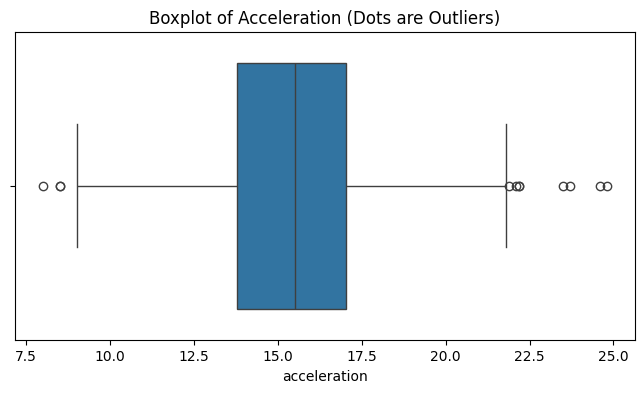

In [72]:
# Plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['acceleration'])
plt.title("Boxplot of Acceleration (Dots are Outliers)")
plt.show()

In [88]:
# 1. Select the column to check
col = df['acceleration']

# 2. Calculate IQR
Q1 = col.quantile(0.25) # 25th percentile
Q3 = col.quantile(0.75) # 75th percentile
IQR = Q3 - Q1

# 3. Define Bounds (Standard rule is 1.5 * IQR)
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

print(f"Normal Range: {lower_bound:.2f} to {upper_bound:.2f}")

# 4. Identify the Outliers
outliers = df[(col < lower_bound) | (col > upper_bound)]

print(f"Number of outliers found: {len(outliers)}")
print("\nHere are the outlier rows:")
print(outliers)

Normal Range: 8.90 to 21.90
Number of outliers found: 11

Here are the outlier rows:
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
7    14.0          8         440.0       215.0    4312           8.5   
9    15.0          8         390.0       190.0    3850           8.5   
11   14.0          8         340.0       160.0    3609           8.0   
58   23.0          4          97.0        54.0    2254          23.5   
193  29.0          4          85.0        52.0    2035          22.2   
194  24.5          4          98.0        60.0    2164          22.1   
207  19.0          4         120.0        88.0    3270          21.9   
297  27.2          4         141.0        71.0    3190          24.8   
298  23.9          8         260.0        90.0    3420          22.2   
324  43.4          4          90.0        48.0    2335          23.7   
388  44.0          4          97.0        52.0    2130          24.6   

     model_year  origin                           

In [91]:
print(f"Median of acceleration: {df['acceleration'].quantile(0.50)}")
print(f"Median of mpg:{df['mpg'].quantile(0.50)}")
print(f"Median of displacement: {df['displacement'].quantile(0.50)}")
print(f"Median of horsepower: {df['horsepower'].quantile(0.50)}")
print(f"Median of weight: {df['weight'].quantile(0.50)}")

Median of acceleration: 15.5
Median of mpg:22.75
Median of displacement: 151.0
Median of horsepower: 93.5
Median of weight: 2803.5


We can see that the first three cars accelerate much faster than the others in the dataset, while the remaining outliers are exceptionally slow. These outliers appear to be rare types: for example, the first three possess large engines and significant horsepower (similar to sports cars or supercars), whereas the slow cars lack powerful engines entirely.

I want the model to be robust across all vehicle types, so I have chosen to keep them. Consequently, I accept that the Normality test (Omnibus) will fail.

I want to find the minimum number of relevant variables against accerlation using Backward Elimination based on BIC.

In [62]:
# 2. Preprocessing
# We drop 'name' because it is a unique text identifier (not useful for regression)
# We separate the target ('acceleration')
X = df.drop(columns=['acceleration', 'name'])
y = df['acceleration']

# Handle Categorical Data: One-hot encode 'origin'
X = pd.get_dummies(X, columns=['origin'], drop_first=True)

# Ensure data is numeric (booleans from get_dummies become floats)
X = X.astype(float)

# Add Intercept (Constant) - Required for statsmodels OLS
X = sm.add_constant(X)

In [63]:
# 3. Define Backward Elimination Function (Minimizing BIC)
def get_best_model_bic(X, y):
    features = list(X.columns)

    while len(features) > 1: # Always keep at least the intercept
        # Fit model with current feature set
        model = sm.OLS(y, X[features]).fit()
        current_bic = model.bic

        # Track the best move
        best_new_bic = current_bic
        feature_to_drop = None

        # Try removing each feature one by one (skip 'const')
        for feature in features:
            if feature == 'const':
                continue

            # Create a temporary list without this feature
            temp_features = [f for f in features if f != feature]

            # Fit temporary model
            temp_model = sm.OLS(y, X[temp_features]).fit()

            # If this results in a lower BIC, mark this feature for deletion
            if temp_model.bic < best_new_bic:
                best_new_bic = temp_model.bic
                feature_to_drop = feature

        # If dropping a feature improved the BIC, update the feature list
        if feature_to_drop:
            features.remove(feature_to_drop)
            print(f"Dropped: {feature_to_drop:<15} (New BIC: {best_new_bic:.2f})")
        else:
            # If no removal improves the model, stop the loop
            break

    return sm.OLS(y, X[features]).fit()

In [64]:
# 4. Run the Algorithm
final_model = get_best_model_bic(X, y)

# 5. Output Results
print("\n" + "="*30)
print("FINAL MODEL SUMMARY")
print("="*30)
print(final_model.summary())

Dropped: origin_usa      (New BIC: 1575.72)
Dropped: origin_japan    (New BIC: 1569.75)
Dropped: mpg             (New BIC: 1564.49)
Dropped: cylinders       (New BIC: 1559.50)
Dropped: model_year      (New BIC: 1555.90)

FINAL MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:           acceleration   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     207.4
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           3.04e-80
Time:                        01:11:52   Log-Likelihood:                -766.01
No. Observations:                 392   AIC:                             1540.
Df Residuals:                     388   BIC:                             1556.
Df Model:                           3                                         
Covariance Type:            nonrobust           

We got the first linear model like in below:

$$\text{Acceleration} = \beta_0 + \beta_1(\text{displacement}) + \beta_2(\text{horsepower}) + \beta_3(\text{weight})$$

Currently, the $R^2$ is only 0.616. This is largely because physics is rarely linear. In this dataset, "Acceleration" is actually measured as the "Time to 60 mph."

In physics:$$Force = Mass \times Acceleration$$

Because power and weight interact to determine how quickly a vehicle reaches a certain speed, the relationship is better expressed as:$$Time \propto \frac{Weight}{Power}$$Because the relationship involves division and interaction (weight and horsepower working together rather than changing independently), a simple straight line struggles to fit the data accurately.

We will use Polynomial Regression (Degree 2). This approach automatically creates:

Squared Terms ($Weight^2$, $HP^2$)to capture the curvature.

Interaction Terms ($Weight \times HP$)to capture how the variables affect each other.

In [65]:
# Now, select ONLY the features found by BIC process
features = ['displacement', 'horsepower', 'weight']
X = df[features]
y = df['acceleration']

In [66]:
# ==========================================
# MODEL 1: The Basic Linear Model (Current)
# ==========================================
model_linear = LinearRegression()

# Perform 10-Fold Cross-Validation
# This splits data into 10 parts, trains on 9, tests on 1, and repeats.
cv_linear = cross_val_score(model_linear, X, y, cv=10, scoring='r2')

In [67]:
# ==========================================
# MODEL 2: Polynomial Model (Degree 2)
# ==========================================
# This creates: x, x^2, y, y^2, x*y, etc.
model_poly = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

cv_poly = cross_val_score(model_poly, X, y, cv=10, scoring='r2')

In [68]:
# ==========================================
# Compare Results
# ==========================================
print(f"1. Linear Model Avg R-Squared:  {cv_linear.mean():.4f}")
print(f"2. Poly Model (deg=2) Avg R2:   {cv_poly.mean():.4f}")

print("-" * 30)

1. Linear Model Avg R-Squared:  0.5279
2. Poly Model (deg=2) Avg R2:   0.6372
------------------------------


In [69]:
model_poly.fit(X, y)

# ====================================================
# EXTRACT DATA FOR SUMMARY
# ====================================================

# A. Extract the polynomial step from the pipeline
poly_step = model_poly.named_steps['polynomialfeatures']

# B. Transform X using that step
# This creates the squared terms and interactions
X_poly_transformed = poly_step.transform(X)

# C. Get the names of the new columns (e.g., "horsepower^2")
poly_names = poly_step.get_feature_names_out(features)

# D. Create a DataFrame so the summary is readable
X_poly_df = pd.DataFrame(X_poly_transformed, columns=poly_names)

# E. Handle the Intercept (Constant)
# PolynomialFeatures usually adds a column named '1' (the constant).
# Statsmodels needs this. If '1' is in columns, we use it. If not, we add it.
if '1' not in X_poly_df.columns:
    X_poly_df = sm.add_constant(X_poly_df)

# ====================================================
# GENERATE SUMMARY
# ====================================================
ols_model = sm.OLS(y, X_poly_df).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           acceleration   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     110.4
Date:                Fri, 16 Jan 2026   Prob (F-statistic):          1.43e-100
Time:                        01:11:53   Log-Likelihood:                -702.39
No. Observations:                 392   AIC:                             1425.
Df Residuals:                     382   BIC:                             1464.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
1                         

While your $R^2$ increased significantly (from 0.616 to 0.722), the model is now over-fitted and contains "noise."

In the summary, look at the column $P>|t|$. We seeing values asscoiate with:

$Horsepower×Weight$

$Weight^2$

$Displacement^2$

Are greater than 0.05, that variable is statistically useless in this specific model.By removing these "dead weight" variables, we will get a cleaner model with the same high accuracy but less complexity (better BIC).

In [70]:
def backward_elimination(X, y):
    cols = list(X.columns)
    while len(cols) > 1:
        # Fit model
        model = sm.OLS(y, X[cols]).fit()

        # Check p-values (Max P-value strategy is safer for Poly terms than BIC alone)
        p_values = model.pvalues
        max_p = p_values.max()
        worst_feature = p_values.idxmax()

        # If the worst feature has P > 0.05, drop it
        if max_p > 0.05:
            # Never drop the intercept ('const' or '1')
            if worst_feature == 'const' or worst_feature == '1':
                break

            cols.remove(worst_feature)
            print(f"Dropped: {worst_feature:<25} (P-value: {max_p:.4f})")
        else:
            break

    return sm.OLS(y, X[cols]).fit()

final_poly_model = backward_elimination(X_poly, y)

Dropped: horsepower weight         (P-value: 0.9278)
Dropped: weight^2                  (P-value: 0.1574)
Dropped: displacement^2            (P-value: 0.0597)
Dropped: displacement horsepower   (P-value: 0.2500)


In [71]:
print(final_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:           acceleration   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     195.9
Date:                Fri, 16 Jan 2026   Prob (F-statistic):          1.57e-103
Time:                        01:11:53   Log-Likelihood:                -705.90
No. Observations:                 392   AIC:                             1424.
Df Residuals:                     386   BIC:                             1448.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  19.3759    

This model is "good enough" and can be the final version.
1. No "Dead Weight" (Perfect P-values): P>|t| all below 0.05.
2. Efficiency (High Accuracy, Low Complexity): old adj. R-squared(0.716, with 9 variables) compare to current adj. R-squared(0.714 with 5 variables),  we dropped 4 complex variables and lost almost zero accuracy (0.005 difference). This makes the model much more robust and less prone to overfitting.
3. The "Physics" Make Sense:

    horsepower & horsepower^2: Acceleration is primarily driven by engine power, but it's not a straight line (diminishing returns), hence the squared term. We keep both because x^2 controls the curvature (how much it bends) and x controls the slope and position of the curve.


    displacement * weight: This interaction term is significant. It suggests that a heavy car needs a larger engine (displacement) to move, and the relationship between engine size and car weight dictates how fast it picks up speed.

Lastly, The Prob(Omnibus) is 0.000. Ideally, we want this >0.05. Whereas, we  choose the model to be robust across all vehicle types, so kept the outliers. Consequently, for a general predictive model, this is acceptable.